In [8]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [9]:
# # print last two rows
inflow_data.tail(2)

,DMA A (L/s),DMA B (L/s),DMA C (L/s),DMA D (L/s),DMA E (L/s),DMA F (L/s),DMA G (L/s),DMA H (L/s),DMA I (L/s),DMA J (L/s)
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,,,,,,,,
2022-07-24 22:00:00,10.42,12.69,6.19,32.83,83.15,9.42,30.68,19.86,18.73,25.57
2022-07-24 23:00:00,11.53,9.81,6.38,25.73,76.62,7.05,28.96,17.08,20.11,25.23


In [10]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

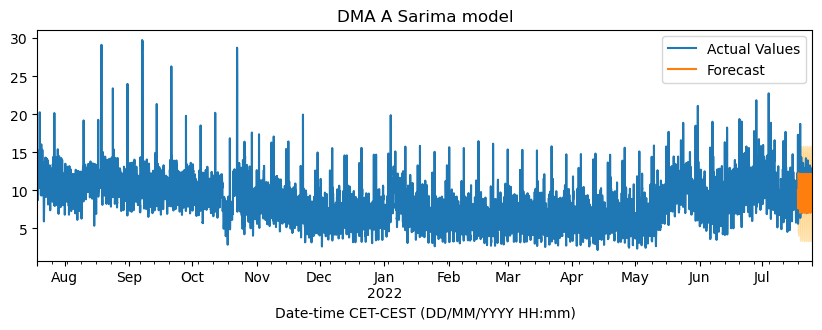

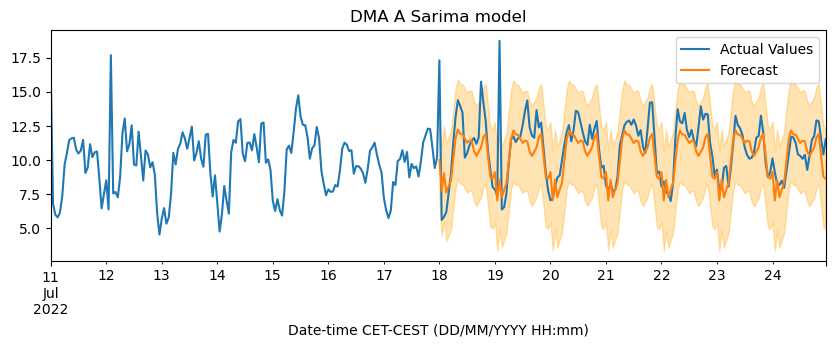

Performance indicators
DMA A Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.62            7.31             1.02           9.95 



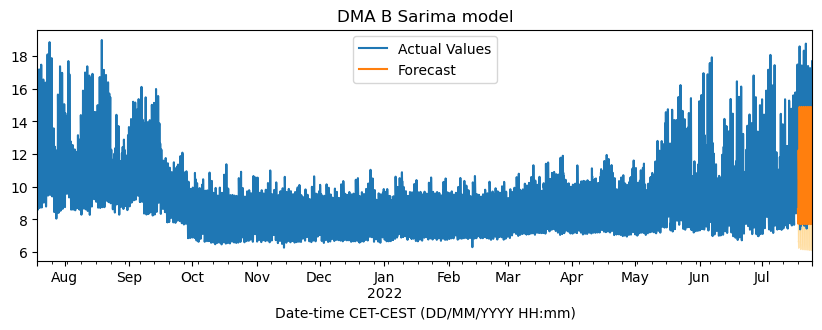

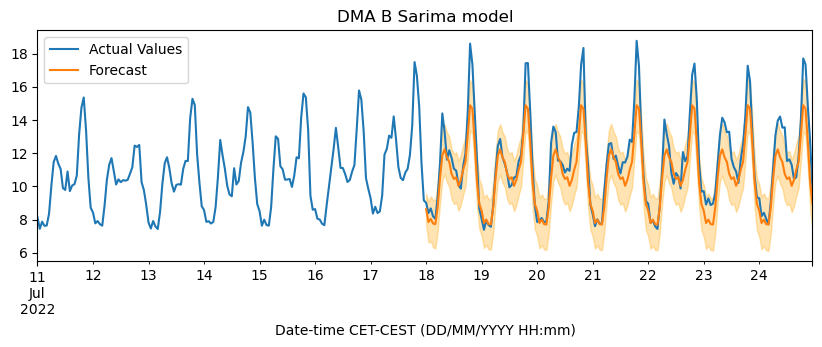

Performance indicators
DMA B Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.94            3.71             0.95           5.60 



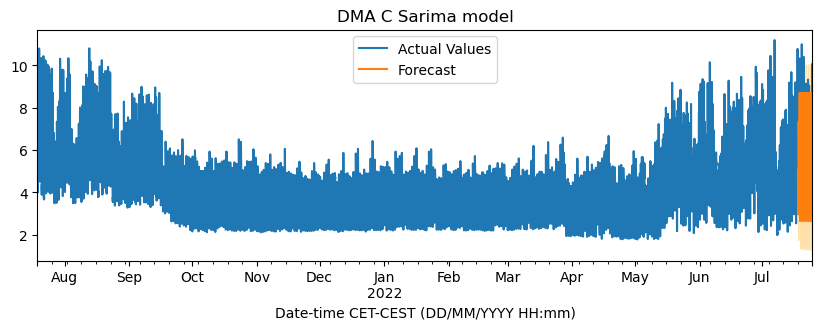

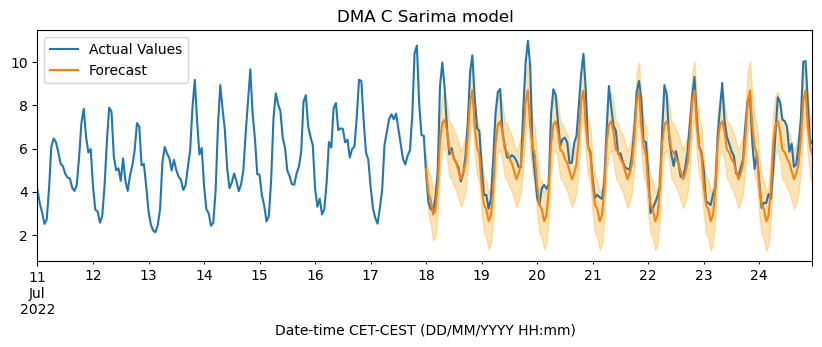

Performance indicators
DMA C Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.72            2.78             0.69           4.20 



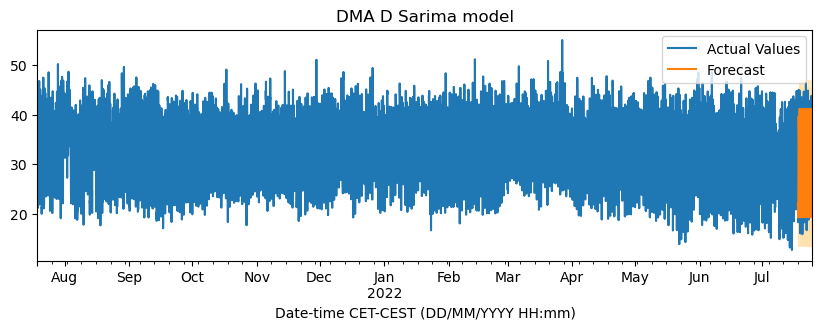

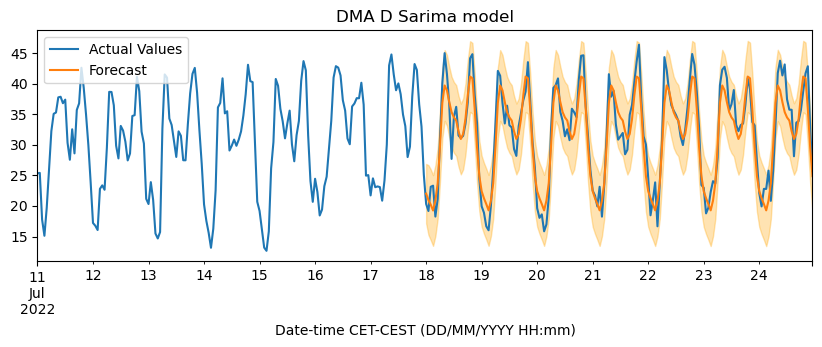

Performance indicators
DMA D Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.30            7.65             2.32           12.27 



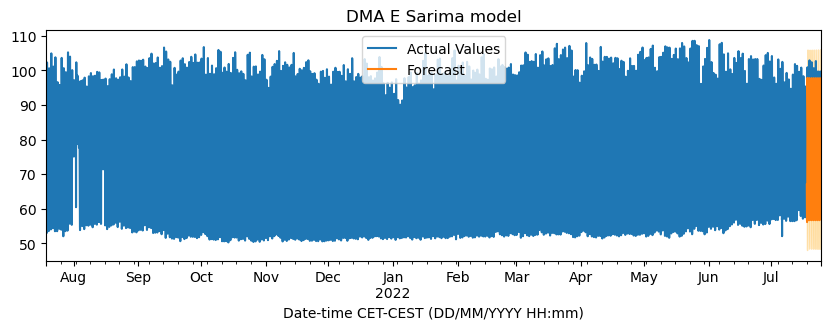

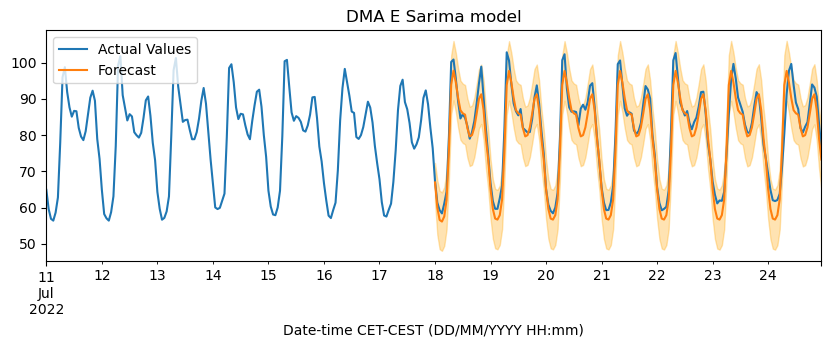

Performance indicators
DMA E Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.36            7.62             2.62           12.60 



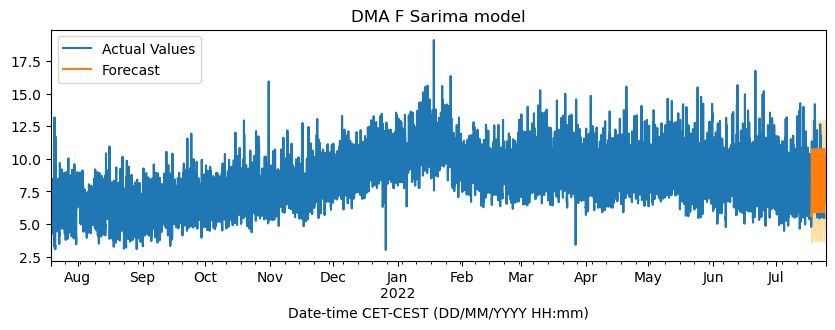

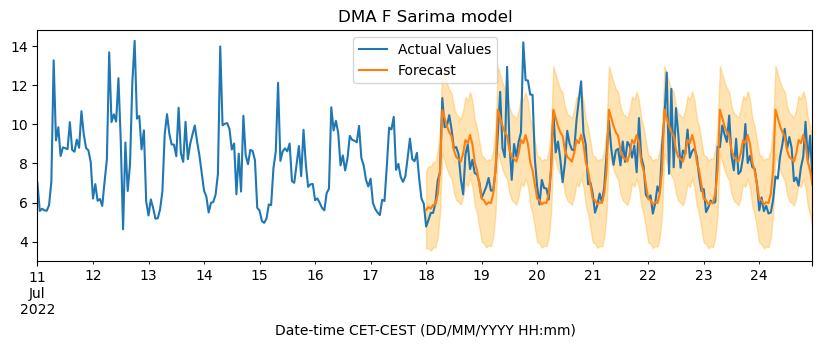

Performance indicators
DMA F Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.56            2.10             0.93           3.59 



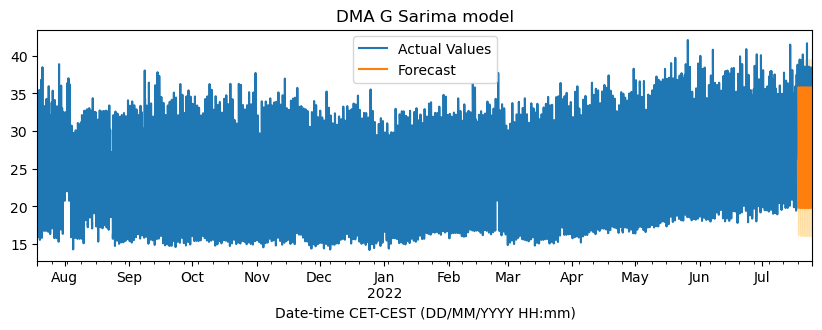

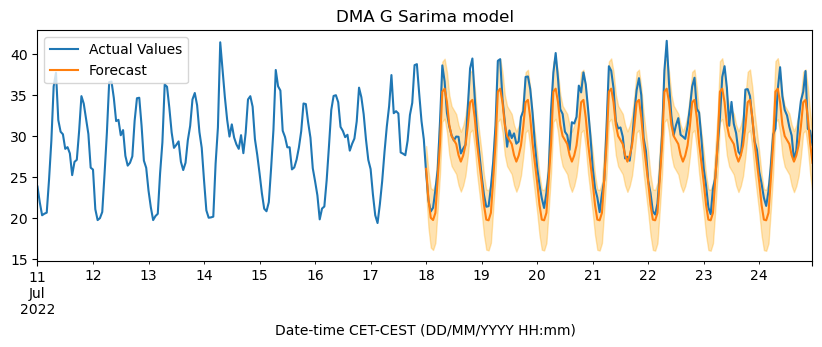

Performance indicators
DMA G Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.54            5.05             2.09           8.68 



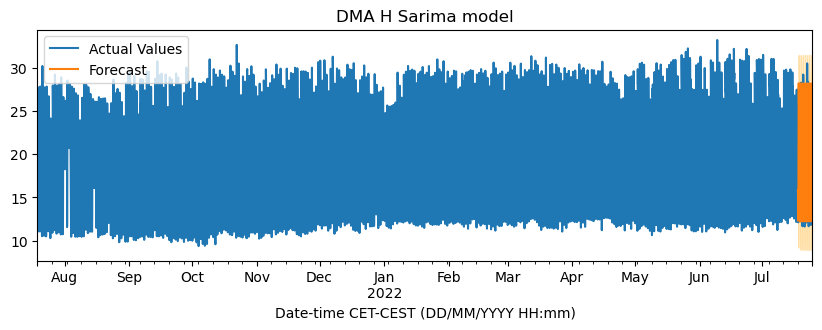

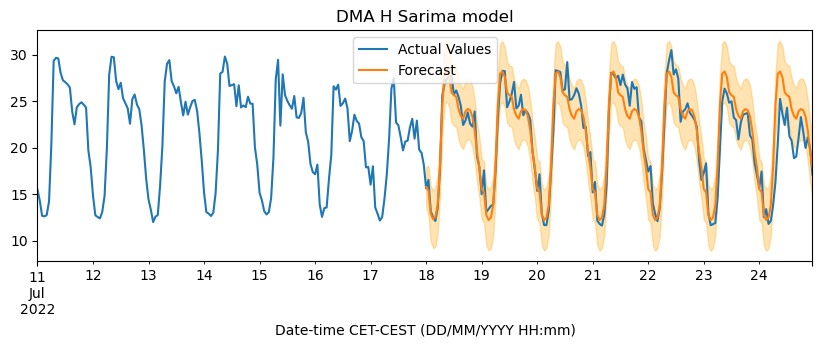

Performance indicators
DMA H Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.75            2.08             1.46           4.28 



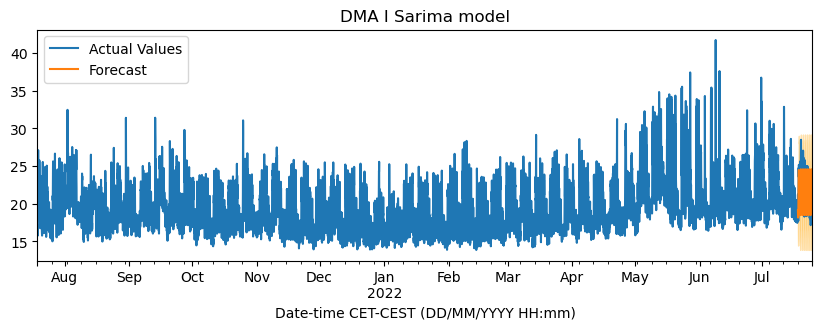

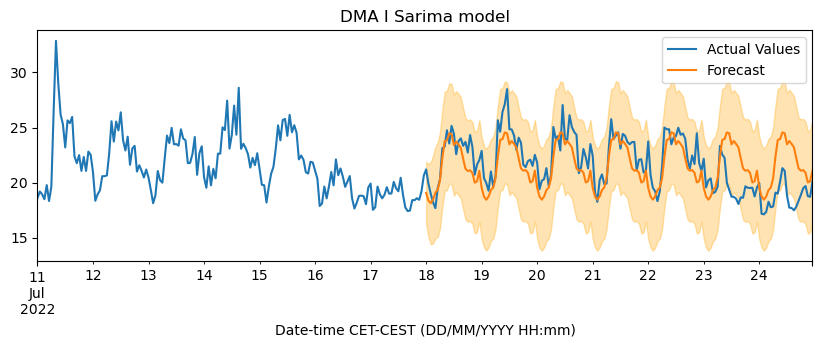

Performance indicators
DMA I Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.16            3.20             1.72           6.08 



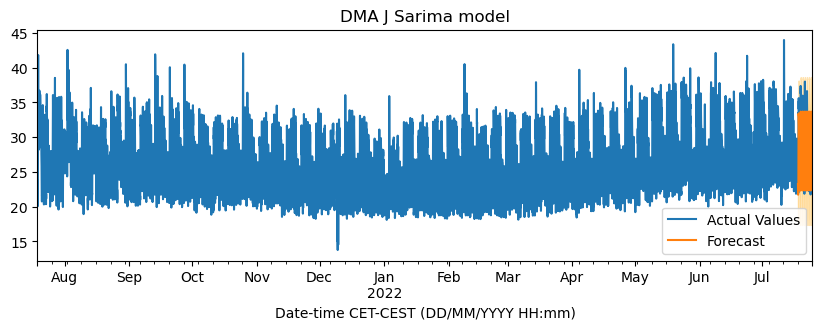

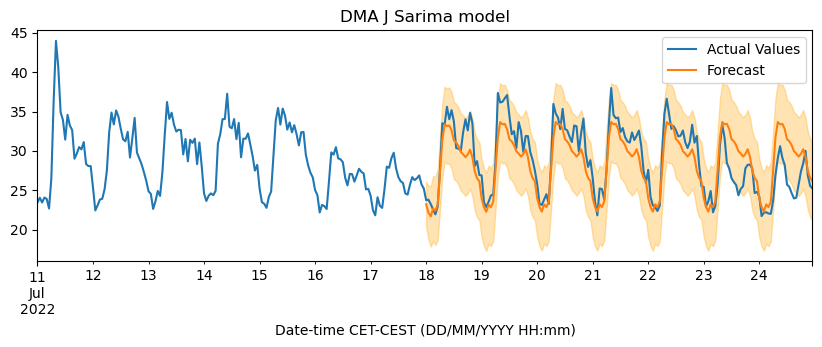

Performance indicators
DMA J Sarima 56-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.66            4.80             2.06           8.53 



In [11]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2021-07-19'
end = '2022-07-24'

# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):

    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    # tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # make array format for analysis
    y = tseries_df

    # define train and test sets
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    #Naive Forecaster
    # fh = ForecastingHorizon(y_test.index, is_relative=False)
    # forecaster = NaiveForecaster(strategy = 'mean')
    # forecaster.fit(y_train)
    # # results of naive forecaster
    # y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarima model
    # the statsmodel package applies the difference already if needed.
    model = ARIMA(y_train, order=(2,0,0), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test)).summary_frame(alpha=0.05)

    # plot forecast and full time series length
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' Sarima model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    # plot forecast and last two weeks of time series
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' Sarima model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' Sarima 52-Weeks',return_df=1)
    results_df = pd.concat([results_df, df])
    #print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [12]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A Sarima 56-Weeks,1.623,7.306,1.017,9.945
DMA B Sarima 56-Weeks,0.942,3.708,0.952,5.602
DMA C Sarima 56-Weeks,0.724,2.783,0.693,4.200
DMA D Sarima 56-Weeks,2.305,7.647,2.318,12.270
DMA E Sarima 56-Weeks,2.359,7.617,2.622,12.599
DMA F Sarima 56-Weeks,0.558,2.100,0.929,3.587
DMA G Sarima 56-Weeks,1.541,5.051,2.086,8.678
DMA H Sarima 56-Weeks,0.751,2.077,1.457,4.284
DMA I Sarima 56-Weeks,1.158,3.197,1.724,6.079
DMA J Sarima 56-Weeks,1.665,4.801,2.060,8.526


In [13]:
print(f"{results_df['Total'].sum() :.2f}")

75.77


In [14]:
print(f"{results_df.drop('DMA E Sarima 52-Weeks')['Total'].sum() :.2f}")

63.17
